In [111]:
import numpy as np
from numpy.random import rand
from landscapeWithOcean import LandscapeWithOcean


import mpl_toolkits.mplot3d.axes3d as p3
    # from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Image Processing Tools
from skimage.filters.rank import entropy 
from skimage.morphology import disk 
from skimage.color import rgb2gray 
from skimage import io 
    # from skimage import img_as_ubyte
    # %config InlineBackend.figure_format = 'retina' 
 

    
# Movie Tools
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Famous_Arts', artist='Matplotlib',comment='Resembles the real thing.')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)


# Stuff
# import matplotlib.animation as animation\n

# %matplotlib osx\n
# import scipy.ndimage\n

from skimage.transform import resize

# Girl With Pearl Earring

In [112]:
### Define simulation grid and initial conditions

NX = 70*1 #number of rows
NY = 70*1 #number of columns

d  = 5 # grid spacing in meters
dx = d # keep dx=dy for simplicity
dy = d

LX=NX*dx
LY=NY*dy

Z = np.zeros([NX, NY]) + 0.1

In [113]:
pearlGirl = io.imread('girlWithPearlEarring.jpg')

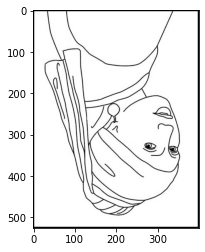

In [114]:
plt.imshow(pearlGirl)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


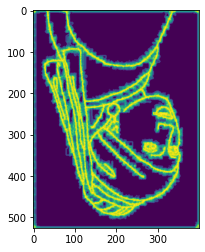

In [115]:
gray_image = rgb2gray(pearlGirl)
grayPearl= entropy(gray_image, disk(2))
plt.imshow(grayPearl)
plt.show()

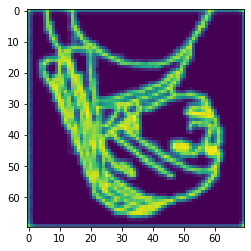

In [116]:
Z = resize(grayPearl, (NX, NY), anti_aliasing=True)
x = np.arange(NX)
y = np.arange(NY)
X,Y = np.meshgrid(y,x)
ZMaxOrg = np.max(Z)

plt.imshow(Z)
plt.show()

In [117]:
K = 0.70e-6 # meters^(1-2m)/yr
D = 0.001 # m^2/yr
uplift = 0.0


dt = d**2 / D / 8
print(' dt[years] = ',dt)

 dt[years] =  3125.0


In [118]:
m=1
n= 0.75
theta_c = 10

T = 500.0 * 1000.0
n_iter = int(np.round(T/dt))
ls = LandscapeWithOcean(NX,NY)
oceanLevelParameter=0.1 
ls.ComputeOceanVolumeFromOceanLevelParameter(Z,NX,NY,oceanLevelParameter)
ls.pool_check(Z,NX,NY)
ls.A = np.zeros((NX,NY))
metadata = dict(title='FinalProject')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)


Minimum elevation           0.0
Maximum elevation           3.527263371500363
Beach level                 0.3527263371500363
Ocean volume                847.3211429573229
Percentage of ocean surface 53.22448979591837


In [119]:
# Set-up figure
def init_figure():
    fig = plt.figure(figsize=(12.,6.))
    plt.show()
    return fig

def update_figure():
        plt.clf()
        ax1 = fig.add_subplot(121,projection='3d')

        # use equal x-y aspect with an explicit vertical exageration
        vert_exag = 4.
        ax1.set_xlim3d(0,max(NX,NY))
        ax1.set_ylim3d(0,max(NX,NY))
        ax1.set_zlim3d(0,ZMaxOrg)

        ax1.set_title('Surface Relief')

#        surf = ax1.plot_surface(X,Y,Z, cmap = cm.terrain, rstride=1, cstride=1,
#                antialiased=False,linewidth=0)

        ZPlot = np.copy(Z)
        ZPlot[ZPlot<ls.ZBeachLevel] = ls.ZBeachLevel 
        ZPlot -= ls.ZBeachLevel
        ax1.plot_surface(X,Y,ZPlot, cmap = cm.terrain, rstride=1, cstride=1,
                antialiased=False,linewidth=0)

        ax2 = fig.add_subplot(122,aspect='equal')
        ax2.set_title('Elevation')

        #im = ax2.pcolor(Z,cmap=cm.terrain)
        im = ax2.pcolor(ZPlot,cmap=cm.coolwarm)
        cs = ax2.contour(ZPlot,6,colors='k')

        # Add a color bar which maps values to colors.
        cbar = fig.colorbar(im, shrink=0.5, aspect=5)
        # Add the contour line levels to the colorbar
        cbar.add_lines(cs)

        #plt.show()
        plt.draw()
        plt.pause(0.0001)

<Figure size 864x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

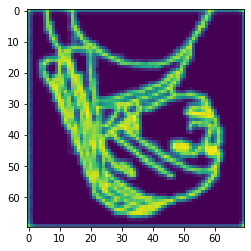

In [120]:
# Set up figure
fig = init_figure()
update_figure()
Znew = np.copy(Z)

plt.imshow(Z)
plt.show()


In [121]:
# Set up figure
fig = init_figure()
update_figure()
Znew = np.copy(Z)
with writer.saving(fig, "GirlWithPearlEarrings.mp4", dpi=200):
    for it in range(1,n_iter+1):

        ls.calculate_collection_area(Z,NX,NY)
        ls.A *= dx*dy

        for i in range(NX):
            iL = np.mod(i-1,NX) # normally i-1 but observe p.b.c.
            iR = np.mod(i+1,NX) # normally i+1 but observe p.b.c.

            for j in range(NY):
                jD = np.mod(j-1,NY) # normally j-1 but observe p.b.c.
                jU = np.mod(j+1,NY) # normally j+1 but observe p.b.c.

                if ls.ocean[i,j]>0:
                    Psi_z  = 0;
                    Phi_z  = 0;
                else:
                    if ls.drain[i,j]>0: #this cell is a drain
                        s1 = (Z[iR,j]  - Z[iL,j] )/(2.*dx)
                        s2 = (Z[i,jU]  - Z[i,jD] )/(2.*dy)
                        s3 = (Z[iR,jD] - Z[iL,jU])/(2. * np.sqrt( dx**2 + dy**2) )
                        s4 = (Z[iR,jU] - Z[iL,jD])/(2. * np.sqrt( dx**2 + dy**2) )
                        gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2))/2.
                        Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)            

                    elif ls.drainage[i,j]>0: #this cell is a drainage point (it drains a pool)

                        if (Z[i,j]>=Z[iR,j]) and ls.pool[iR,j]!=ls.drainage[i,j]: 
                            gradient = (Z[i,j]-Z[iR,j])/dx #pool is on my left, I drain to the right, use this gradiant
                        elif (Z[i,j]>=Z[iL,j]) and ls.pool[iL,j]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[iL,j])/dx
                        elif (Z[i,j]>=Z[i,jU]) and ls.pool[i,jU]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[i,jU])/dy
                        elif (Z[i,j]>=Z[i,jD]) and ls.pool[i,jD]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[i,jD])/dy
                        else:
                            gradient = 0.02 # ??? This does happen (maybe when two pools merge)
                        Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)

                    else: #this cell is a pool, assume it has some mass diffusion but no erosion!
                        Psi_z = 0.

                    if (Psi_z<0):
                        Psi_z = 0. 

                    # diffusion term
                    Phi_z = D * ( (Z[iR,j] - 2.*Z[i,j] + Z[iL,j]) / dx**2 \
                                + (Z[i,jU] - 2.*Z[i,j] + Z[i,jD]) / dx**2 )

                Znew[i,j] = Z[i,j] + (Phi_z - Psi_z + uplift )*dt  

                dZdt= (Znew[i,j] - Z[i,j]) / dt
                CFL = abs(dZdt) * dt / min(dx,dy)
                if (CFL>1.0):
                    print('\nWarning: Time step of',dt,'is probably too large. Safer would be:',dt/CFL)

                if (Znew[i,j]<0.):
                    Znew[i,j] = 0. # yes, this does happen at the boundary when kept at zero

        #Znew[0,:] = 0.0 # resets front boundary to 0
        Z = np.copy(Znew)

        ls.pool_check(Z,NX,NY)

        if (np.mod(it,10)==0): 
            print(it,end='')
            update_figure()
            writer.grab_frame()
            
            print(' Ocean level=',ls.ZBeachLevel,' Ocean surface fraction=',100*ls.AOcean/(NX*NY));
        else:
            print('.',end='')

    update_figure()
    writer.grab_frame()
    
    print(' Simulation finished.')

<Figure size 864x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

.........10

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3533894829174906  Ocean surface fraction= 54.46938775510204
.........20

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3501319283613088  Ocean surface fraction= 59.63265306122449
.........30

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34938528182448786  Ocean surface fraction= 64.0204081632653
.........40

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34924725080731134  Ocean surface fraction= 66.38775510204081
.........50

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34911011870219183  Ocean surface fraction= 68.77551020408163
.........60

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34909195705423085  Ocean surface fraction= 70.3265306122449
.........70

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489870028040226  Ocean surface fraction= 71.63265306122449
.........80

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489456720398289  Ocean surface fraction= 72.3265306122449
.........90

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34893738070143443  Ocean surface fraction= 73.22448979591837
.........100

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489343360640879  Ocean surface fraction= 73.71428571428571
.........110

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34892806337498417  Ocean surface fraction= 74.28571428571429
.........120

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489259334953922  Ocean surface fraction= 74.85714285714286
.........130

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489252768684552  Ocean surface fraction= 75.51020408163265
.........140

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489242713361481  Ocean surface fraction= 76.10204081632654
.........150

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3489242713361481  Ocean surface fraction= 76.48979591836735
.........160

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.34892299856518566  Ocean surface fraction= 77.0204081632653


<Figure size 432x288 with 0 Axes>

 Simulation finished.


In [ ]:
pearlGirlColor = io.imread('girlWithPearlEarring.jpeg')

In [ ]:
plt.imshow(pearlGirl)
plt.show()

In [ ]:
def PrintArrayInfo(a): 
    print("Array info:") 
    print("shape:", a.shape) 
    print("dtype:", a.dtype) 
    print("min, max:", a.min(), a.max()) 

In [ ]:
N = 7
from PIL import Image
#Load Image into PIL
image = pearlGirl
imageRGB = Image.fromarray(img_as_ubyte(image))
imageIndexed = imageRGB.quantize(colors=N, kmeans=1)

PrintArrayInfo(np.array(imageIndexed))

In [ ]:
rgbFromIndexed = imageIndexed.convert("RGB")

print(rgbFromIndexed.getcolors())


# counts: The number of pixels for each of the six colors
# palette: The RGB tuple (e.g. (196, 213, 206) ) for each of the six colors
# labels: The integer label for each of the six colors.
counts = np.array([])
labels = np.arange(0, 7)
items = np.array(rgbFromIndexed.getcolors(), dtype=object)
counts = items[:,0]
palette = items[:,1]

print(counts)
print(" ")
print(palette)
print(" ")
print(labels)    

In [ ]:
from image_manipulation import bar_plot_with_colors
bar_plot_with_colors(counts,palette,labels)

# Mona Lisa

In [93]:
### Define simulation grid and initial conditions

NX = 70*1 #number of rows
NY = 70*1 #number of columns

d  = 5 # grid spacing in meters
dx = d # keep dx=dy for simplicity
dy = d

LX=NX*dx
LY=NY*dy

Z = np.zeros([NX, NY]) + 0.1

In [103]:
monaLisa = io.imread('monaLisa2.jpeg')

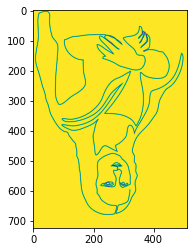

In [104]:
plt.imshow(monaLisa)
plt.show()

/var/folders/f7/0bl6fspd1sb34bvb06bv0bkh0000gn/T/ipykernel_14865/2724819372.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_image = rgb2gray(monaLisa)


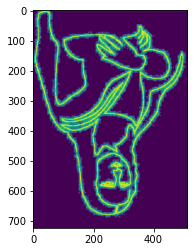

In [105]:
gray_image = rgb2gray(monaLisa)
grayLisa= entropy(gray_image, disk(2))
plt.imshow(grayLisa)
plt.show()

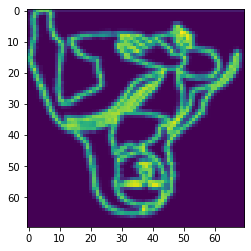

In [106]:
Z = resize(grayLisa, (NX, NY), anti_aliasing=True)
x = np.arange(NX)
y = np.arange(NY)
X,Y = np.meshgrid(y,x)
ZMaxOrg = np.max(Z)

plt.imshow(Z)
plt.show()

In [107]:
K = 0.70e-6 # meters^(1-2m)/yr
D = 0.001 # m^2/yr
uplift = 0.0


dt = d**2 / D / 8
print(' dt[years] = ',dt)

 dt[years] =  3125.0


In [108]:
m=1
n= 0.75
theta_c = 10

T = 500.0 * 1000.0
n_iter = int(np.round(T/dt))
ls = LandscapeWithOcean(NX,NY)
oceanLevelParameter=0.1 
ls.ComputeOceanVolumeFromOceanLevelParameter(Z,NX,NY,oceanLevelParameter)
ls.pool_check(Z,NX,NY)
ls.A = np.zeros((NX,NY))
metadata = dict(title='FinalProject')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)


Minimum elevation           0.0
Maximum elevation           3.2516156068565234
Beach level                 0.3251615606856524
Ocean volume                971.4016618524457
Percentage of ocean surface 66.04081632653062


In [109]:
# Set-up figure
def init_figure():
    fig = plt.figure(figsize=(12.,6.))
    plt.show()
    return fig

def update_figure():
        plt.clf()
        ax1 = fig.add_subplot(121,projection='3d')

        # use equal x-y aspect with an explicit vertical exageration
        vert_exag = 4.
        ax1.set_xlim3d(0,max(NX,NY))
        ax1.set_ylim3d(0,max(NX,NY))
        ax1.set_zlim3d(0,ZMaxOrg)

        ax1.set_title('Surface Relief')

#        surf = ax1.plot_surface(X,Y,Z, cmap = cm.terrain, rstride=1, cstride=1,
#                antialiased=False,linewidth=0)

        ZPlot = np.copy(Z)
        ZPlot[ZPlot<ls.ZBeachLevel] = ls.ZBeachLevel 
        ZPlot -= ls.ZBeachLevel
        ax1.plot_surface(X,Y,ZPlot, cmap = cm.terrain, rstride=1, cstride=1,
                antialiased=False,linewidth=0)

        ax2 = fig.add_subplot(122,aspect='equal')
        ax2.set_title('Elevation')

        #im = ax2.pcolor(Z,cmap=cm.terrain)
        im = ax2.pcolor(ZPlot,cmap=cm.coolwarm)
        cs = ax2.contour(ZPlot,6,colors='k')

        # Add a color bar which maps values to colors.
        cbar = fig.colorbar(im, shrink=0.5, aspect=5)
        # Add the contour line levels to the colorbar
        cbar.add_lines(cs)

        #plt.show()
        plt.draw()
        plt.pause(0.0001)

In [110]:
# Set up figure
fig = init_figure()
update_figure()
Znew = np.copy(Z)
with writer.saving(fig, "MonaLisa.mp4", dpi=200):
    for it in range(1,n_iter+1):

        ls.calculate_collection_area(Z,NX,NY)
        ls.A *= dx*dy

        for i in range(NX):
            iL = np.mod(i-1,NX) # normally i-1 but observe p.b.c.
            iR = np.mod(i+1,NX) # normally i+1 but observe p.b.c.

            for j in range(NY):
                jD = np.mod(j-1,NY) # normally j-1 but observe p.b.c.
                jU = np.mod(j+1,NY) # normally j+1 but observe p.b.c.

                if ls.ocean[i,j]>0:
                    Psi_z  = 0;
                    Phi_z  = 0;
                else:
                    if ls.drain[i,j]>0: #this cell is a drain
                        s1 = (Z[iR,j]  - Z[iL,j] )/(2.*dx)
                        s2 = (Z[i,jU]  - Z[i,jD] )/(2.*dy)
                        s3 = (Z[iR,jD] - Z[iL,jU])/(2. * np.sqrt( dx**2 + dy**2) )
                        s4 = (Z[iR,jU] - Z[iL,jD])/(2. * np.sqrt( dx**2 + dy**2) )
                        gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2))/2.
                        Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)            

                    elif ls.drainage[i,j]>0: #this cell is a drainage point (it drains a pool)

                        if (Z[i,j]>=Z[iR,j]) and ls.pool[iR,j]!=ls.drainage[i,j]: 
                            gradient = (Z[i,j]-Z[iR,j])/dx #pool is on my left, I drain to the right, use this gradiant
                        elif (Z[i,j]>=Z[iL,j]) and ls.pool[iL,j]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[iL,j])/dx
                        elif (Z[i,j]>=Z[i,jU]) and ls.pool[i,jU]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[i,jU])/dy
                        elif (Z[i,j]>=Z[i,jD]) and ls.pool[i,jD]!=ls.drainage[i,j]:
                            gradient = (Z[i,j]-Z[i,jD])/dy
                        else:
                            gradient = 0.02 # ??? This does happen (maybe when two pools merge)
                        Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)

                    else: #this cell is a pool, assume it has some mass diffusion but no erosion!
                        Psi_z = 0.

                    if (Psi_z<0):
                        Psi_z = 0. 

                    # diffusion term
                    Phi_z = D * ( (Z[iR,j] - 2.*Z[i,j] + Z[iL,j]) / dx**2 \
                                + (Z[i,jU] - 2.*Z[i,j] + Z[i,jD]) / dx**2 )

                Znew[i,j] = Z[i,j] + (Phi_z - Psi_z + uplift )*dt  

                dZdt= (Znew[i,j] - Z[i,j]) / dt
                CFL = abs(dZdt) * dt / min(dx,dy)
                if (CFL>1.0):
                    print('\nWarning: Time step of',dt,'is probably too large. Safer would be:',dt/CFL)

                if (Znew[i,j]<0.):
                    Znew[i,j] = 0. # yes, this does happen at the boundary when kept at zero

        #Znew[0,:] = 0.0 # resets front boundary to 0
        Z = np.copy(Znew)

        ls.pool_check(Z,NX,NY)

        if (np.mod(it,10)==0): 
            print(it,end='')
            update_figure()
            writer.grab_frame()
            
            print(' Ocean level=',ls.ZBeachLevel,' Ocean surface fraction=',100*ls.AOcean/(NX*NY));
        else:
            print('.',end='')

    update_figure()
    writer.grab_frame()
    
    print(' Simulation finished.')

<Figure size 864x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

.........10

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32641230462859605  Ocean surface fraction= 66.18367346938776
.........20

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3245107427202559  Ocean surface fraction= 71.3061224489796
.........30

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32406283220447446  Ocean surface fraction= 77.40816326530613
.........40

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.323931606006591  Ocean surface fraction= 80.14285714285714
.........50

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3238388928858914  Ocean surface fraction= 81.3265306122449
.........60

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32380359205829173  Ocean surface fraction= 82.63265306122449
.........70

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32379172000527484  Ocean surface fraction= 83.95918367346938
.........80

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3237835018724919  Ocean surface fraction= 84.81632653061224
.........90

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32378280075970445  Ocean surface fraction= 85.48979591836735
.........100

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32377862424315346  Ocean surface fraction= 86.36734693877551
.........110

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32377604835552753  Ocean surface fraction= 86.89795918367346
.........120

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3237752896763158  Ocean surface fraction= 87.42857142857143
.........130

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32370320440852546  Ocean surface fraction= 88.28571428571429
.........140

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3237021895323876  Ocean surface fraction= 88.89795918367346
.........150

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.32370123376416804  Ocean surface fraction= 89.42857142857143
.........160

<Figure size 432x288 with 0 Axes>

 Ocean level= 0.3237010711946523  Ocean surface fraction= 90.20408163265306


<Figure size 432x288 with 0 Axes>

 Simulation finished.
